# Notebook 1: Data Loading & Exploratory Data Analysis

**OSU Campus Energy Analysis — Data I/O 2026 Advanced Track**

This notebook establishes the data foundation for all downstream analysis. We load all 12 months of smart meter data (~9M rows), building metadata (1,287 buildings), and hourly weather data, then perform comprehensive data quality auditing, utility profiling, and temporal/spatial exploration.

**Key outputs:** Cleaned, merged parquet files partitioned by utility type for efficient downstream analysis.

In [77]:
%pip install seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pathlib import Path
import geopandas as gpd
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')

# Style settings
sns.set_theme(style='whitegrid', font_scale=1.1)
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100


CORE_DIR = Path('advanced_core')
BONUS_DIR = Path("advanced_bonus")
OUTPUT_DIR = Path("processed")


print('Libraries loaded. Ready to go.')


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Libraries loaded. Ready to go.


## 1. Data Loading

We load all 12 monthly meter-reading CSVs with explicit dtypes for memory efficiency, then concatenate into a single DataFrame. Building metadata and weather data are loaded separately.

In [78]:
# Define meter data files across both directories
meter_files = sorted(list(CORE_DIR.glob('meter-readings-*.csv')) + list(BONUS_DIR.glob('meter-readings-*.csv')))
print(f'Found {len(meter_files)} meter data files:')
for f in meter_files:
    print(f'  {f.name}')

# Optimized dtypes for memory efficiency
meter_dtypes = {
    'meterid': 'int32',
    'siteid': 'int32',
    'sitename': 'str',
    'simscode': 'str',
    'utility': 'category',
    'readingvalue': 'float64',
    'readingunits': 'category',
    'readingunitsdisplay': 'category',
    'expectedwindowreadings': 'int16',
    'totalwindowreadings': 'int16',
    'missingwindowreadings': 'int16',
    'filteredwindowreadings': 'int16',
    'readingwindowsum': 'float64',
    'readingwindowmean': 'float64',
    'readingwindowstandarddeviation': 'float64',
    'readingwindowmin': 'float64',
    'readingwindowmax': 'float64',
    'year': 'int16',
    'month': 'str',
    'day': 'str',
}

date_cols = ['readingtime', 'readingwindowstart', 'readingwindowend', 'readingwindowmintime', 'readingwindowmaxtime']

# Load and concatenate all months
dfs = []
for f in meter_files:
    df_chunk = pd.read_csv(f, dtype=meter_dtypes, parse_dates=date_cols)
    dfs.append(df_chunk)
    print(f'  Loaded {f.name}: {len(df_chunk):,} rows')

meter = pd.concat(dfs, ignore_index=True)
del dfs  # free memory

# CRITICAL FIX: Normalize simscode by stripping leading zeros for join compatibility.
# The CSV stores simscodes like "069" while building_metadata uses "69".
# Per the documentation, simsCode is an integer field — leading zeros are artifacts.
meter['simscode'] = meter['simscode'].apply(lambda x: str(int(x)) if x not in (None, 'None', '') and x == x else x)

print(f'\nTotal meter data: {len(meter):,} rows, {meter.memory_usage(deep=True).sum() / 1e9:.2f} GB')

Found 12 meter data files:
  meter-readings-aug-2025.csv
  meter-readings-dec-2025.csv
  meter-readings-july-2025.csv
  meter-readings-june-2025.csv
  meter-readings-may-2025.csv
  meter-readings-nov-2025.csv
  meter-readings-oct-2025.csv
  meter-readings-sept-2025.csv
  meter-readings-april-2025.csv
  meter-readings-feb-2025.csv
  meter-readings-jan-2025.csv
  meter-readings-march-2025.csv
  Loaded meter-readings-aug-2025.csv: 760,368 rows
  Loaded meter-readings-dec-2025.csv: 766,320 rows
  Loaded meter-readings-july-2025.csv: 760,368 rows
  Loaded meter-readings-june-2025.csv: 735,840 rows
  Loaded meter-readings-may-2025.csv: 760,368 rows
  Loaded meter-readings-nov-2025.csv: 737,184 rows
  Loaded meter-readings-oct-2025.csv: 760,368 rows
  Loaded meter-readings-sept-2025.csv: 735,840 rows
  Loaded meter-readings-april-2025.csv: 735,840 rows
  Loaded meter-readings-feb-2025.csv: 687,456 rows
  Loaded meter-readings-jan-2025.csv: 763,344 rows
  Loaded meter-readings-march-2025.csv: 

In [79]:
# Load building metadata
buildings = pd.read_csv(CORE_DIR / 'building_metadata.csv')
buildings['constructiondate'] = pd.to_datetime(buildings['constructiondate'], errors='coerce')
buildings['buildingnumber'] = buildings['buildingnumber'].astype(str)
buildings['building_age'] = 2025 - buildings['constructiondate'].dt.year
print(f'Building metadata: {len(buildings):,} buildings')
print(f'Campuses: {buildings["campusname"].value_counts().to_dict()}')

# Load weather data
weather = pd.read_csv(CORE_DIR / 'weather_data_hourly_2025.csv', parse_dates=['date'])
weather['date_only'] = weather['date'].dt.date
weather['hour'] = weather['date'].dt.hour
print(f'\nWeather data: {len(weather):,} hourly records')
print(f'Date range: {weather["date"].min()} to {weather["date"].max()}')
print(f'Columns: {list(weather.columns)}')

Building metadata: 1,287 buildings
Campuses: {'Columbus': 485, 'Satellite': 331, 'Wooster': 254, 'Medical Center': 125, 'Mansfield': 37, 'Newark': 23, 'Marion': 17, 'Lima': 15}

Weather data: 8,688 hourly records
Date range: 2025-01-01 00:00:00 to 2025-12-31 23:00:00
Columns: ['date', 'latitude', 'longitude', 'temperature_2m', 'shortwave_radiation', 'direct_radiation', 'diffuse_radiation', 'direct_normal_irradiance', 'relative_humidity_2m', 'dew_point_2m', 'precipitation', 'wind_speed_10m', 'wind_speed_100m', 'wind_direction_100m', 'wind_direction_10m', 'cloud_cover', 'apparent_temperature', 'partition_0', 'date_only', 'hour']


## 2. Schema Validation & Join Key Coverage

We verify the join keys between datasets. The critical link is `building_metadata.buildingnumber` → `meter_data.simscode`.

In [80]:
# Join key analysis: simscode <-> buildingnumber
meter_simscodes = set(meter['simscode'].dropna().unique())
building_numbers = set(buildings['buildingnumber'].unique())

matched = meter_simscodes & building_numbers
orphan_meters = meter_simscodes - building_numbers  # meters with no building match
unmetered_buildings = building_numbers - meter_simscodes  # buildings with no meter

print(f'Unique simscodes in meter data: {len(meter_simscodes)}')
print(f'Unique building numbers in metadata: {len(building_numbers)}')
print(f'Matched (inner join): {len(matched)} ({100*len(matched)/len(meter_simscodes):.1f}% of meters)')
print(f'Orphan meters (no building match): {len(orphan_meters)}')
print(f'Unmetered buildings: {len(unmetered_buildings)}')

# How many rows have 'None' simscode?
none_simscodes = meter[meter['simscode'] == 'None']
print(f'\nRows with simscode="None": {len(none_simscodes):,} ({100*len(none_simscodes)/len(meter):.1f}%)')

# Coverage of matched meters in total rows
matched_rows = meter[meter['simscode'].isin(matched)]
print(f'Rows with valid building match: {len(matched_rows):,} ({100*len(matched_rows)/len(meter):.1f}%)')

Unique simscodes in meter data: 288
Unique building numbers in metadata: 1287
Matched (inner join): 285 (99.0% of meters)
Orphan meters (no building match): 3
Unmetered buildings: 1002

Rows with simscode="None": 0 (0.0%)
Rows with valid building match: 8,833,008 (98.5%)


## 3. Data Quality Audit

We analyze data completeness using the `missingwindowreadings`, `filteredwindowreadings`, `totalwindowreadings`, and `expectedwindowreadings` fields. This tells us how reliable each meter's data is.

In [81]:
# Compute data quality metrics per row
meter['pct_missing'] = meter['missingwindowreadings'] / meter['expectedwindowreadings'] * 100
meter['pct_filtered'] = meter['filteredwindowreadings'] / meter['expectedwindowreadings'] * 100
meter['pct_valid'] = (meter['totalwindowreadings'] - meter['missingwindowreadings'] - meter['filteredwindowreadings']) / meter['expectedwindowreadings'] * 100

# Overall data quality summary
print('=== Data Quality Summary ===')
print(f'Mean % missing readings per row: {meter["pct_missing"].mean():.2f}%')
print(f'Mean % filtered readings per row: {meter["pct_filtered"].mean():.2f}%')
print(f'Rows with >50% missing: {(meter["pct_missing"] > 50).sum():,} ({100*(meter["pct_missing"] > 50).mean():.2f}%)')
print(f'Rows with 0% missing (perfect): {(meter["pct_missing"] == 0).sum():,} ({100*(meter["pct_missing"] == 0).mean():.2f}%)')

=== Data Quality Summary ===
Mean % missing readings per row: 7.75%
Mean % filtered readings per row: 0.00%
Rows with >50% missing: 694,536 (7.75%)
Rows with 0% missing (perfect): 8,263,752 (92.18%)


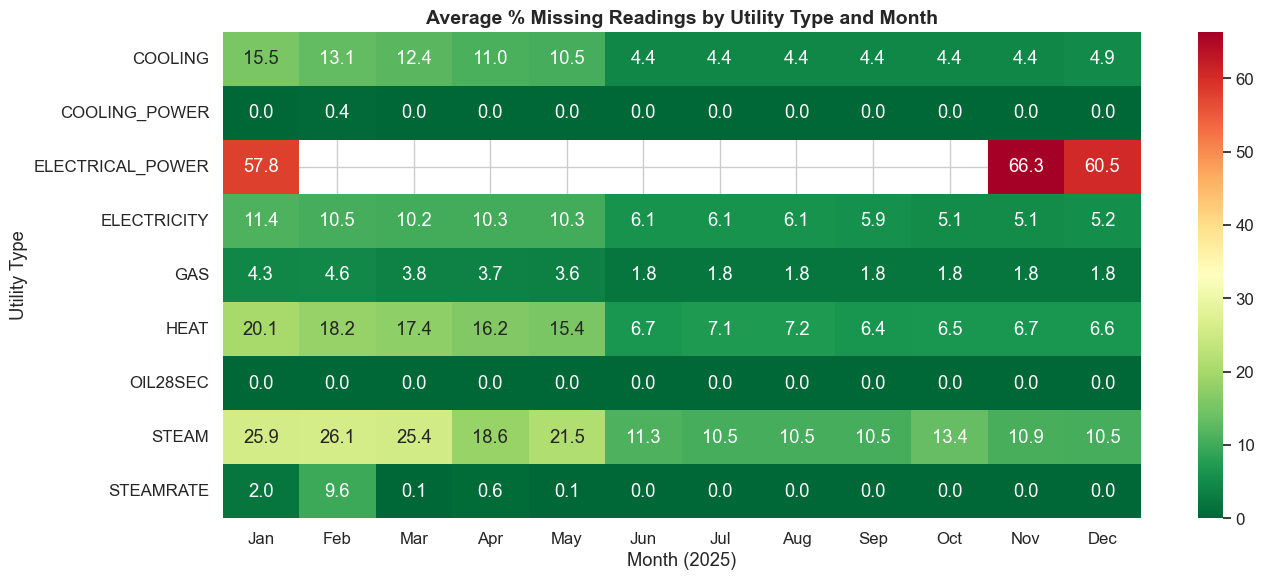

In [82]:
# Data quality heatmap: completeness by month and utility
meter['month_num'] = meter['readingtime'].dt.month
quality_pivot = meter.groupby(['month_num', 'utility'])['pct_missing'].mean().reset_index()
quality_wide = quality_pivot.pivot(index='utility', columns='month_num', values='pct_missing')

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(quality_wide, annot=True, fmt='.1f', cmap='RdYlGn_r', ax=ax,
            xticklabels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax.set_title('Average % Missing Readings by Utility Type and Month', fontsize=14, fontweight='bold')
ax.set_ylabel('Utility Type')
ax.set_xlabel('Month (2025)')
plt.tight_layout()
plt.show()

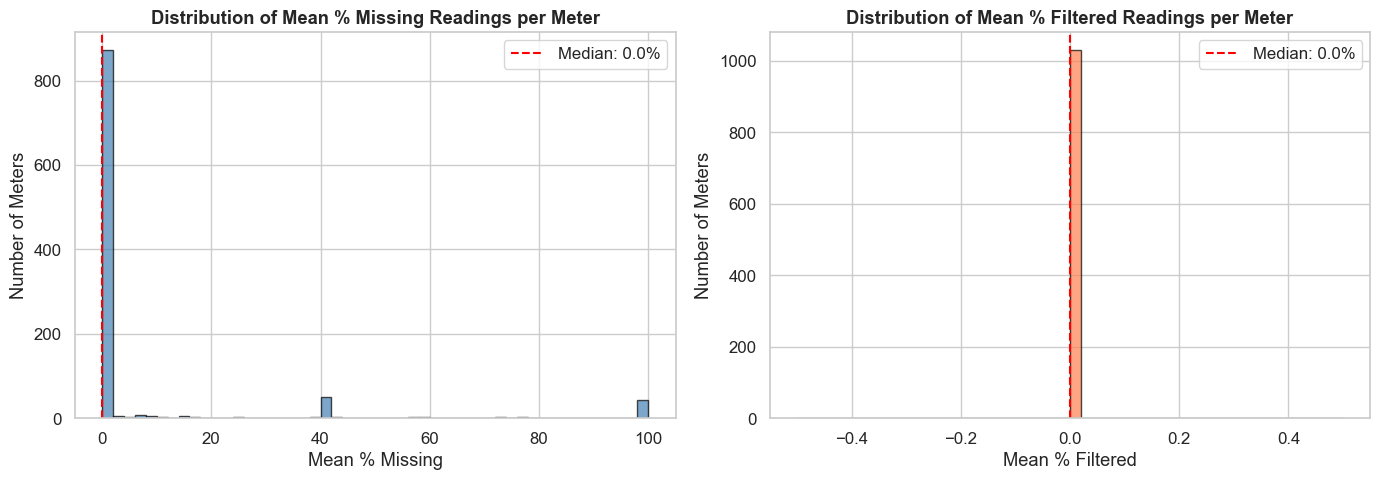

Meters with >25% average missing readings: 120
Meters with >25% average filtered readings: 0


In [83]:
# Per-meter quality: identify worst offenders
meter_quality = meter.groupby('meterid').agg(
    total_rows=('readingvalue', 'count'),
    mean_pct_missing=('pct_missing', 'mean'),
    mean_pct_filtered=('pct_filtered', 'mean'),
    utility=('utility', 'first')
).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(meter_quality['mean_pct_missing'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Mean % Missing Readings per Meter', fontweight='bold')
axes[0].set_xlabel('Mean % Missing')
axes[0].set_ylabel('Number of Meters')
axes[0].axvline(meter_quality['mean_pct_missing'].median(), color='red', linestyle='--', label=f'Median: {meter_quality["mean_pct_missing"].median():.1f}%')
axes[0].legend()

axes[1].hist(meter_quality['mean_pct_filtered'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_title('Distribution of Mean % Filtered Readings per Meter', fontweight='bold')
axes[1].set_xlabel('Mean % Filtered')
axes[1].set_ylabel('Number of Meters')
axes[1].axvline(meter_quality['mean_pct_filtered'].median(), color='red', linestyle='--', label=f'Median: {meter_quality["mean_pct_filtered"].median():.1f}%')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f'Meters with >25% average missing readings: {(meter_quality["mean_pct_missing"] > 25).sum()}')
print(f'Meters with >25% average filtered readings: {(meter_quality["mean_pct_filtered"] > 25).sum()}')

## 4. Utility Profiling

Per the documentation, utilities fall into two categories that **must not be mixed**:
- **Energy utilities** (cumulative): ELECTRICITY (kWh), STEAM (kg), HEAT (kWh), GAS (kWh), COOLING (ton-hr), OIL28SEC (kWh — legacy fuel oil)
- **Power utilities** (instantaneous): ELECTRICAL_POWER (kW), STEAMRATE (kg/hr), COOLING_POWER (tons)

We profile each utility type separately. Per the docs: "Analyze one utility at a time" and "clearly distinguish between energy and power."

In [84]:
# Utility type counts and classification (per documentation Section 2.3)
# Energy utilities represent consumption over time; Power utilities represent instantaneous demand/flow.
ENERGY_UTILITIES = ['ELECTRICITY', 'STEAM', 'HEAT', 'GAS', 'COOLING', 'OIL28SEC']
POWER_UTILITIES = ['ELECTRICAL_POWER', 'STEAMRATE', 'COOLING_POWER']

utility_summary = meter.groupby('utility').agg(
    row_count=('readingvalue', 'count'),
    n_meters=('meterid', 'nunique'),
    n_buildings=('simscode', 'nunique'),
    mean_value=('readingvalue', 'mean'),
    median_value=('readingvalue', 'median'),
    units=('readingunits', 'first')
).reset_index()
utility_summary['category'] = utility_summary['utility'].apply(
    lambda u: 'Energy' if u in ENERGY_UTILITIES else 'Power'
)

print('=== Utility Profiling (per documentation Section 2.3) ===')
print(utility_summary.to_string(index=False))
print(f'\nNote: Utilities are NOT directly comparable. Each has different units.')
print(f'Energy utilities measure consumption over time; Power utilities measure instantaneous demand.')

=== Utility Profiling (per documentation Section 2.3) ===
         utility  row_count  n_meters  n_buildings   mean_value  median_value   units category
         COOLING    1106672       137           87 3.234280e+05     17.106446     kWh   Energy
   COOLING_POWER       9669         2            2 1.169902e+06 726815.158946      kW    Power
ELECTRICAL_POWER        688         2            1 6.904035e+07      0.000000      kW    Power
     ELECTRICITY    4121651       513          279 1.667680e+04     17.288903     kWh   Energy
             GAS    1388934       163          150 1.645380e+08      0.000000     kWh   Energy
            HEAT    1302135       168          135 1.557401e+04     20.712577     kWh   Energy
        OIL28SEC      52557         6            1 2.971961e+06      0.000000     kWh   Energy
           STEAM     278911        38           29 8.847224e+09     71.160925      kg   Energy
       STEAMRATE       8675         1            1 4.866447e+02    535.453109 kg/hour  

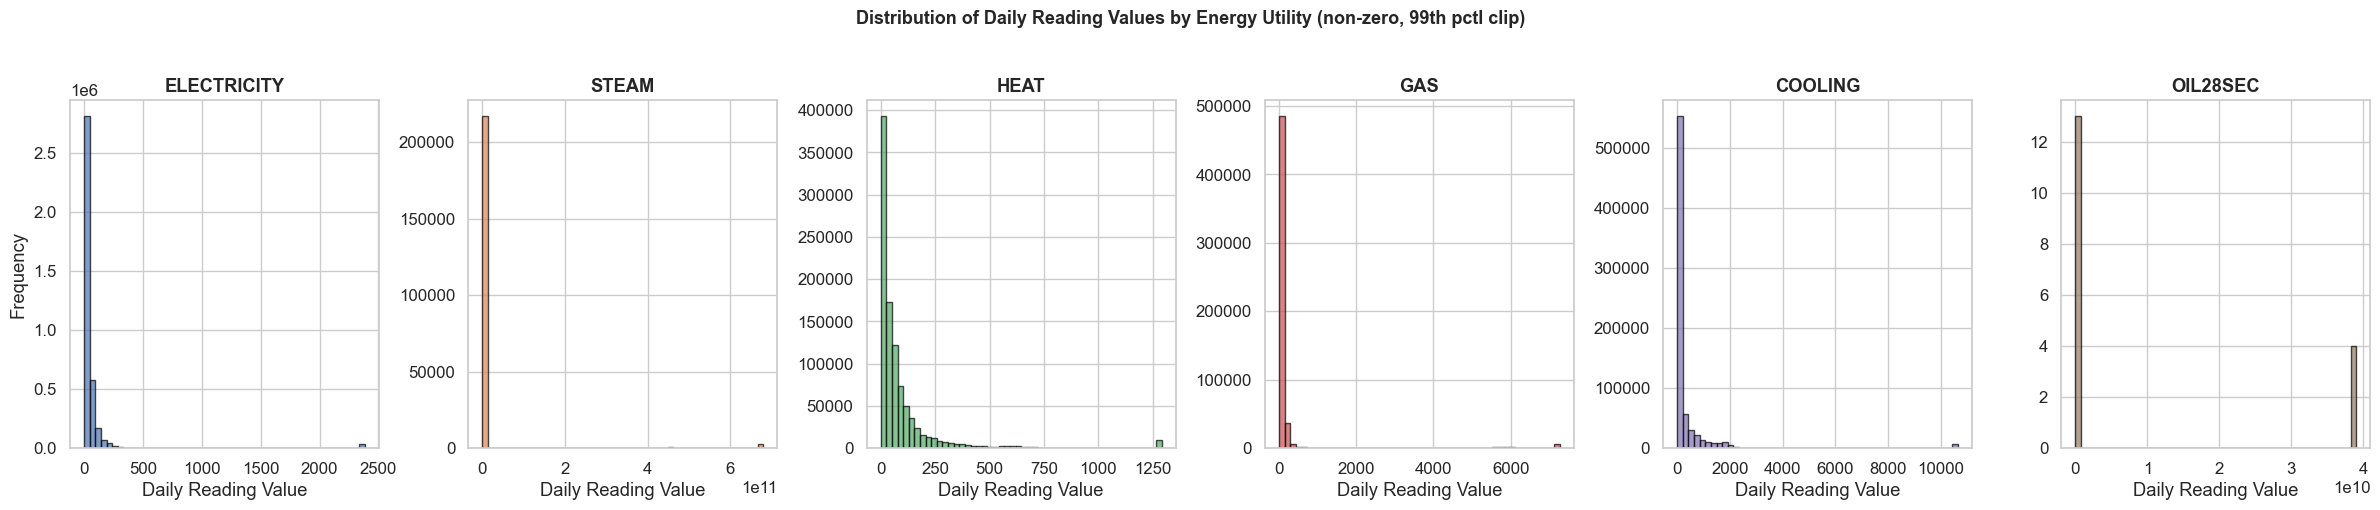

In [85]:
# Distribution of reading values per energy utility
energy_meter = meter[meter['utility'].isin(ENERGY_UTILITIES)]
energy_utils_present = [u for u in ENERGY_UTILITIES if u in energy_meter['utility'].unique()]

n_cols = len(energy_utils_present)
fig, axes = plt.subplots(1, n_cols, figsize=(4*n_cols, 5), sharey=False)
if n_cols == 1:
    axes = [axes]
for i, util in enumerate(energy_utils_present):
    subset = energy_meter[energy_meter['utility'] == util]['readingvalue']
    if len(subset) > 0:
        # Remove zeros and clip at 99th percentile for visualization
        nonzero = subset[subset > 0]
        if len(nonzero) > 0:
            axes[i].hist(nonzero.clip(upper=nonzero.quantile(0.99)), bins=50, 
                        color=sns.color_palette()[i % len(sns.color_palette())], edgecolor='black', alpha=0.7)
    axes[i].set_title(f'{util}', fontweight='bold')
    axes[i].set_xlabel('Daily Reading Value')
    if i == 0:
        axes[i].set_ylabel('Frequency')

fig.suptitle('Distribution of Daily Reading Values by Energy Utility (non-zero, 99th pctl clip)', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

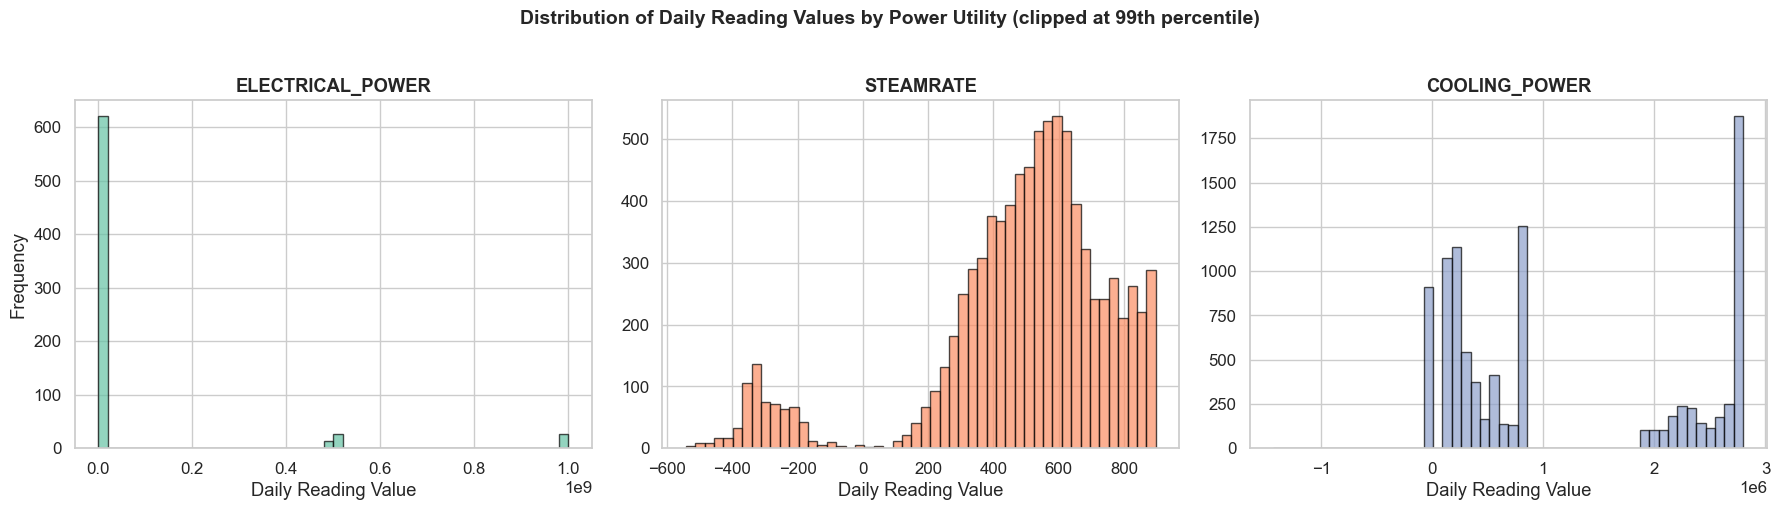

In [86]:
# Distribution for power utilities
power_meter = meter[meter['utility'].isin(POWER_UTILITIES)]
power_utils_present = [u for u in POWER_UTILITIES if u in power_meter['utility'].unique() and len(power_meter[power_meter['utility'] == u]) > 0]

if power_utils_present:
    fig, axes = plt.subplots(1, len(power_utils_present), figsize=(6*len(power_utils_present), 5))
    if len(power_utils_present) == 1:
        axes = [axes]
    for i, util in enumerate(power_utils_present):
        subset = power_meter[power_meter['utility'] == util]['readingvalue']
        if len(subset) > 0:
            axes[i].hist(subset.clip(upper=subset.quantile(0.99)), bins=50, color=sns.color_palette('Set2')[i], edgecolor='black', alpha=0.7)
        axes[i].set_title(f'{util}', fontweight='bold')
        axes[i].set_xlabel('Daily Reading Value')
        if i == 0:
            axes[i].set_ylabel('Frequency')
    fig.suptitle('Distribution of Daily Reading Values by Power Utility (clipped at 99th percentile)', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print('No power utilities found in data.')

## 5. Temporal Patterns

We examine how energy consumption varies across the year, across days of the week, and across hours of the day. These patterns reveal operational schedules, seasonal HVAC loads, and campus occupancy.

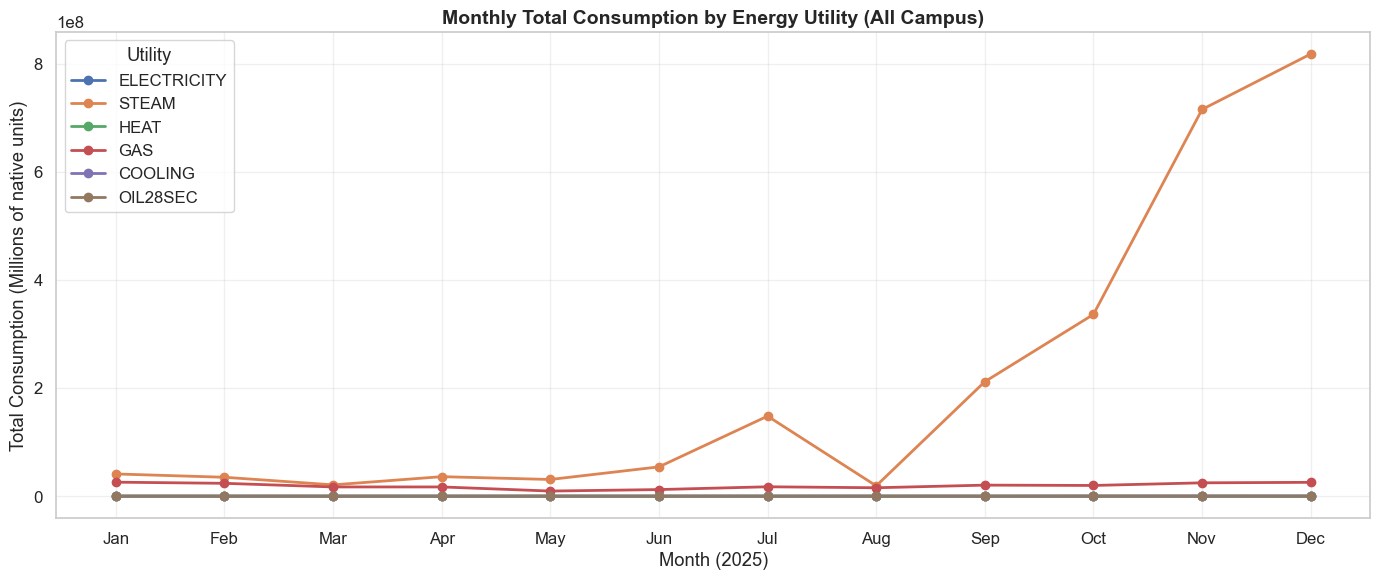

In [87]:
# Monthly consumption trends for energy utilities
monthly_energy = energy_meter.groupby(['month_num', 'utility'])['readingvalue'].sum().reset_index()

fig, ax = plt.subplots(figsize=(14, 6))
for util in ENERGY_UTILITIES:
    subset = monthly_energy[monthly_energy['utility'] == util]
    if len(subset) > 0:
        ax.plot(subset['month_num'], subset['readingvalue'] / 1e6, marker='o', linewidth=2, label=util)

ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax.set_title('Monthly Total Consumption by Energy Utility (All Campus)', fontsize=14, fontweight='bold')
ax.set_xlabel('Month (2025)')
ax.set_ylabel('Total Consumption (Millions of native units)')
ax.legend(title='Utility')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

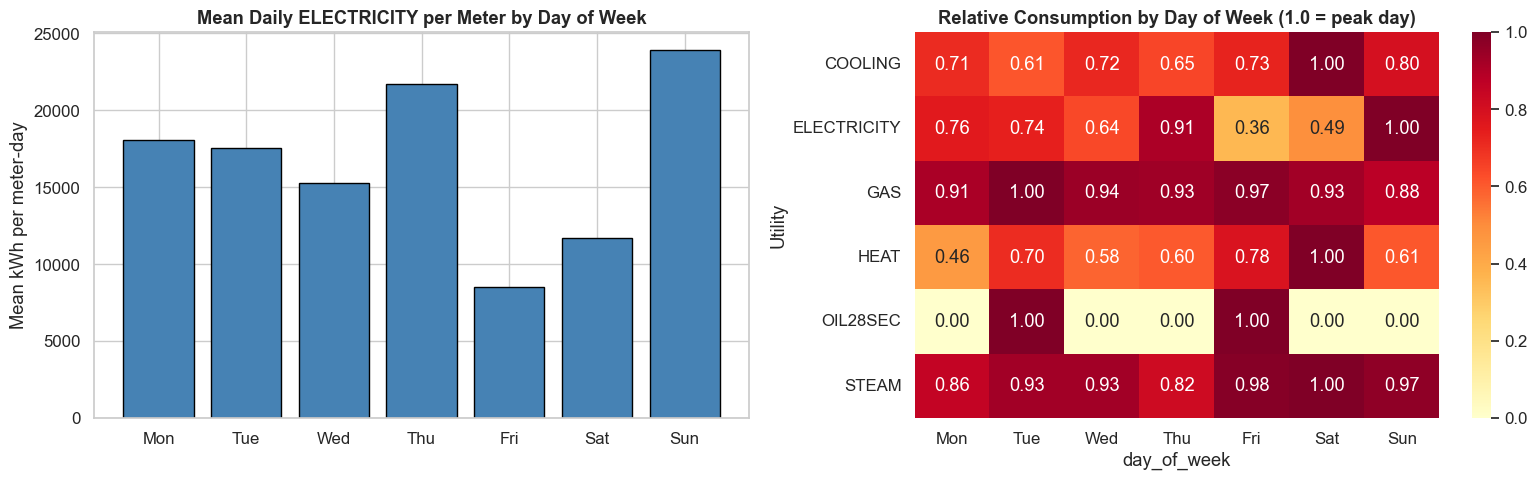

In [88]:
# Day-of-week patterns
meter['day_of_week'] = meter['readingtime'].dt.dayofweek  # 0=Mon, 6=Sun
meter['day_name'] = meter['readingtime'].dt.day_name()

dow_energy = energy_meter.copy()
dow_energy['day_of_week'] = dow_energy['readingtime'].dt.dayofweek
dow_pivot = dow_energy.groupby(['day_of_week', 'utility'])['readingvalue'].mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Electricity day-of-week
elec_dow = dow_pivot[dow_pivot['utility'] == 'ELECTRICITY']
day_names = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
axes[0].bar(elec_dow['day_of_week'], elec_dow['readingvalue'], color='steelblue', edgecolor='black')
axes[0].set_xticks(range(7))
axes[0].set_xticklabels(day_names)
axes[0].set_title('Mean Daily ELECTRICITY per Meter by Day of Week', fontweight='bold')
axes[0].set_ylabel('Mean kWh per meter-day')

# Heatmap: day of week vs utility
dow_wide = dow_pivot.pivot(index='utility', columns='day_of_week', values='readingvalue')
# Normalize each row to show relative patterns
dow_norm = dow_wide.div(dow_wide.max(axis=1), axis=0)
sns.heatmap(dow_norm, annot=True, fmt='.2f', cmap='YlOrRd', ax=axes[1],
            xticklabels=day_names)
axes[1].set_title('Relative Consumption by Day of Week (1.0 = peak day)', fontweight='bold')
axes[1].set_ylabel('Utility')

plt.tight_layout()
plt.show()

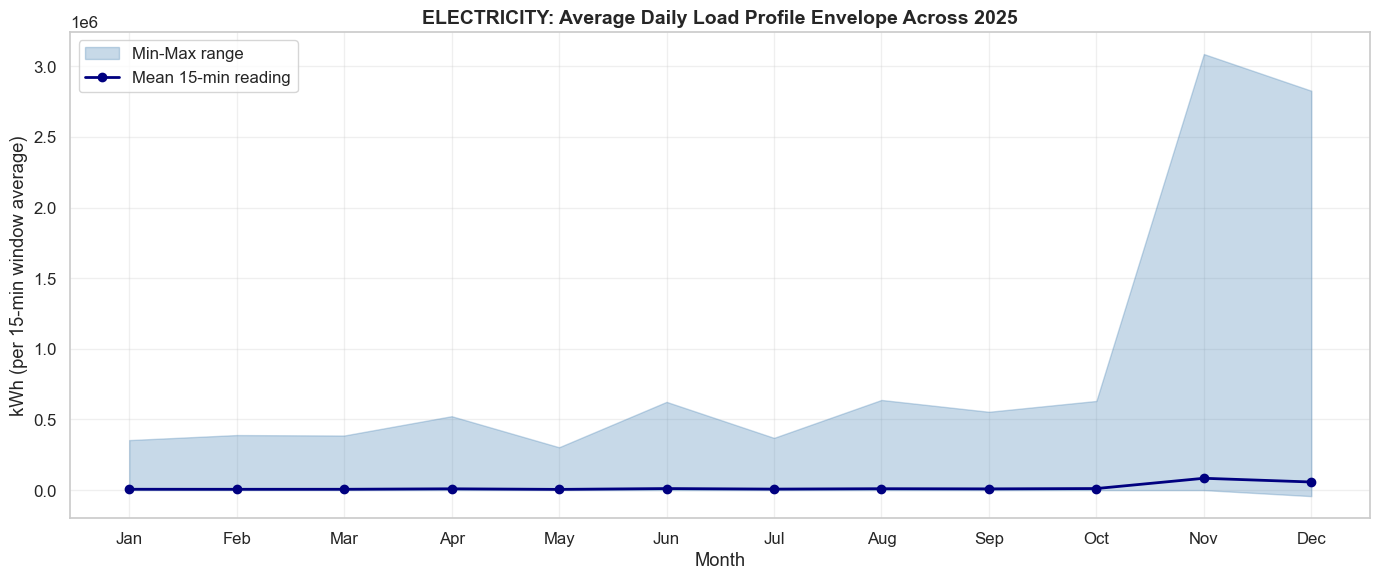

The spread between min and max indicates daily load variability.
Wider spreads suggest more pronounced day/night cycles.


In [89]:
# Hourly load profiles using readingwindowmin/max/mean
# The readingwindowmean gives us the average 15-min reading across the day
# readingwindowmin/max give the daily min and max 15-min readings
# These indicate load shape within each day

elec = meter[meter['utility'] == 'ELECTRICITY'].copy()

# Monthly load shape variation using min/max/mean
monthly_load = elec.groupby('month_num').agg(
    avg_daily_mean=('readingwindowmean', 'mean'),
    avg_daily_min=('readingwindowmin', 'mean'),
    avg_daily_max=('readingwindowmax', 'mean')
).reset_index()

fig, ax = plt.subplots(figsize=(14, 6))
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax.fill_between(monthly_load['month_num'], monthly_load['avg_daily_min'], monthly_load['avg_daily_max'], alpha=0.3, color='steelblue', label='Min-Max range')
ax.plot(monthly_load['month_num'], monthly_load['avg_daily_mean'], 'o-', color='navy', linewidth=2, label='Mean 15-min reading')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(months)
ax.set_title('ELECTRICITY: Average Daily Load Profile Envelope Across 2025', fontsize=14, fontweight='bold')
ax.set_xlabel('Month')
ax.set_ylabel('kWh (per 15-min window average)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print('The spread between min and max indicates daily load variability.')
print('Wider spreads suggest more pronounced day/night cycles.')

## 6. Building Profiling

We merge meter data with building metadata to analyze consumption by campus, building age, and building size. This reveals how building characteristics influence energy use.

Merged dataset: 8,833,008 rows (98.5% of original)


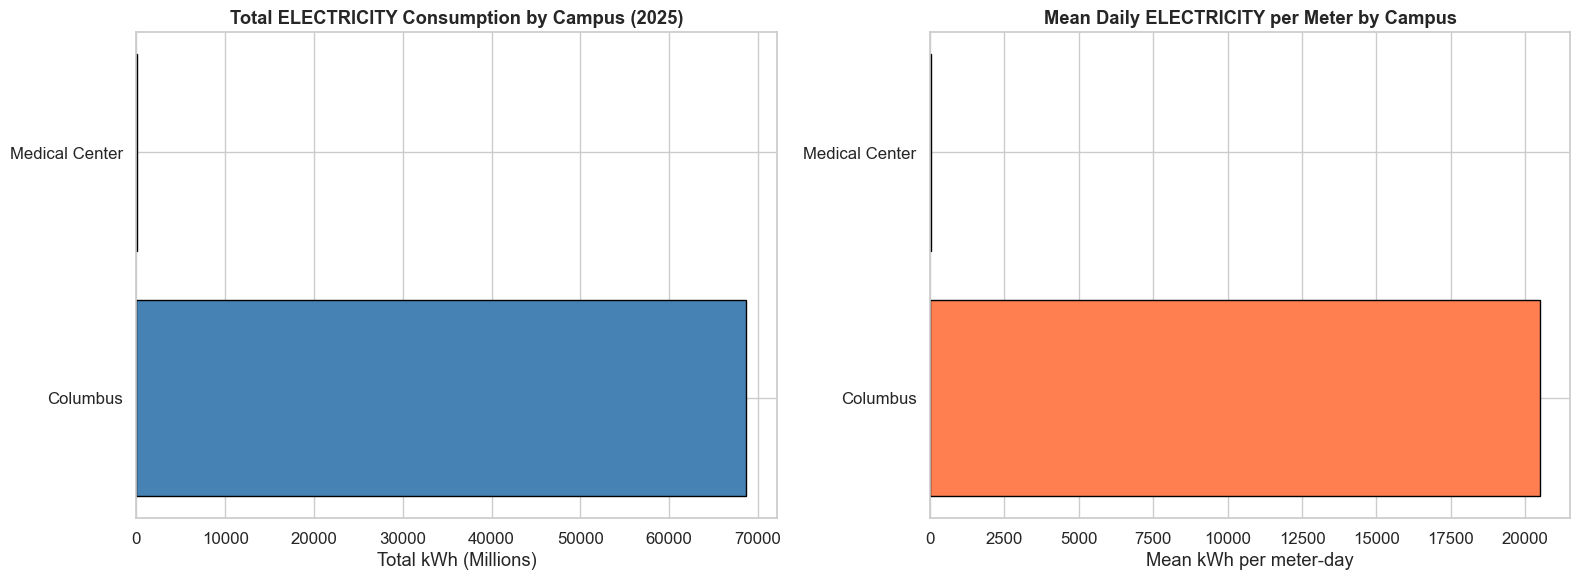

In [90]:
# Merge meter data with building metadata
meter_bldg = meter.merge(buildings, left_on='simscode', right_on='buildingnumber', how='inner')
print(f'Merged dataset: {len(meter_bldg):,} rows ({100*len(meter_bldg)/len(meter):.1f}% of original)')

# Annual electricity consumption by campus
elec_bldg = meter_bldg[meter_bldg['utility'] == 'ELECTRICITY']
campus_elec = elec_bldg.groupby('campusname')['readingvalue'].agg(['sum', 'mean', 'count']).reset_index()
campus_elec.columns = ['campus', 'total_kwh', 'mean_daily_kwh', 'meter_days']
campus_elec = campus_elec.sort_values('total_kwh', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].barh(campus_elec['campus'], campus_elec['total_kwh'] / 1e6, color='steelblue', edgecolor='black')
axes[0].set_title('Total ELECTRICITY Consumption by Campus (2025)', fontweight='bold')
axes[0].set_xlabel('Total kWh (Millions)')

# Mean daily consumption per meter by campus
axes[1].barh(campus_elec['campus'], campus_elec['mean_daily_kwh'], color='coral', edgecolor='black')
axes[1].set_title('Mean Daily ELECTRICITY per Meter by Campus', fontweight='bold')
axes[1].set_xlabel('Mean kWh per meter-day')

plt.tight_layout()
plt.show()

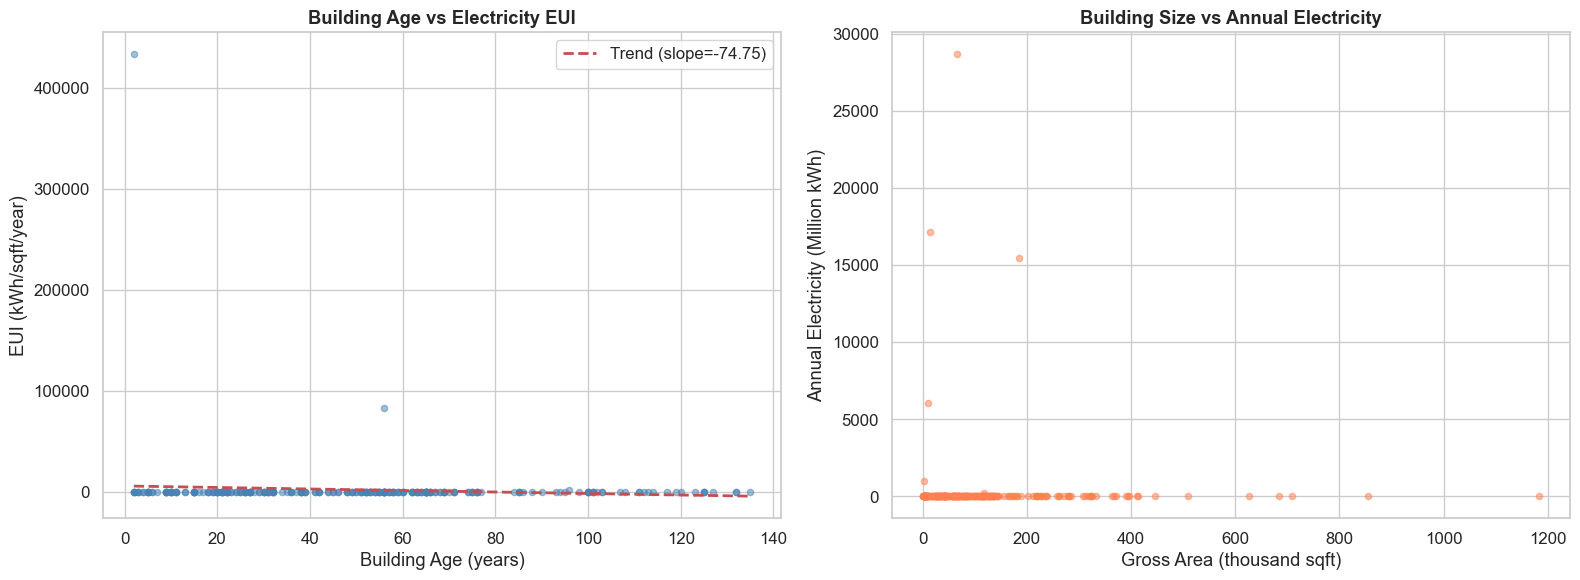

In [91]:
# Consumption by building age
elec_bldg_annual = elec_bldg.groupby(['simscode', 'buildingname', 'building_age', 'grossarea', 'campusname']).agg(
    annual_kwh=('readingvalue', 'sum'),
    n_days=('readingvalue', 'count')
).reset_index()
elec_bldg_annual['grossarea'] = pd.to_numeric(elec_bldg_annual['grossarea'], errors='coerce')
elec_bldg_annual['eui'] = elec_bldg_annual['annual_kwh'] / elec_bldg_annual['grossarea']  # kWh/sqft

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Age vs EUI
valid = elec_bldg_annual.dropna(subset=['building_age', 'eui'])
valid = valid[(valid['eui'] > 0) & (valid['eui'] < valid['eui'].quantile(0.99))]
axes[0].scatter(valid['building_age'], valid['eui'], alpha=0.5, s=20, c='steelblue')
axes[0].set_title('Building Age vs Electricity EUI', fontweight='bold')
axes[0].set_xlabel('Building Age (years)')
axes[0].set_ylabel('EUI (kWh/sqft/year)')

# Add trend line
from numpy.polynomial import polynomial as P
mask = valid['building_age'].notna() & valid['eui'].notna()
if mask.sum() > 10:
    coeffs = np.polyfit(valid.loc[mask, 'building_age'], valid.loc[mask, 'eui'], 1)
    x_fit = np.linspace(valid['building_age'].min(), valid['building_age'].max(), 100)
    axes[0].plot(x_fit, np.polyval(coeffs, x_fit), 'r--', linewidth=2, label=f'Trend (slope={coeffs[0]:.2f})')
    axes[0].legend()

# Size (gross area) vs annual consumption
valid2 = elec_bldg_annual.dropna(subset=['grossarea', 'annual_kwh'])
valid2 = valid2[(valid2['grossarea'] > 0) & (valid2['annual_kwh'] > 0)]
axes[1].scatter(valid2['grossarea'] / 1000, valid2['annual_kwh'] / 1e6, alpha=0.5, s=20, c='coral')
axes[1].set_title('Building Size vs Annual Electricity', fontweight='bold')
axes[1].set_xlabel('Gross Area (thousand sqft)')
axes[1].set_ylabel('Annual Electricity (Million kWh)')

plt.tight_layout()
plt.show()

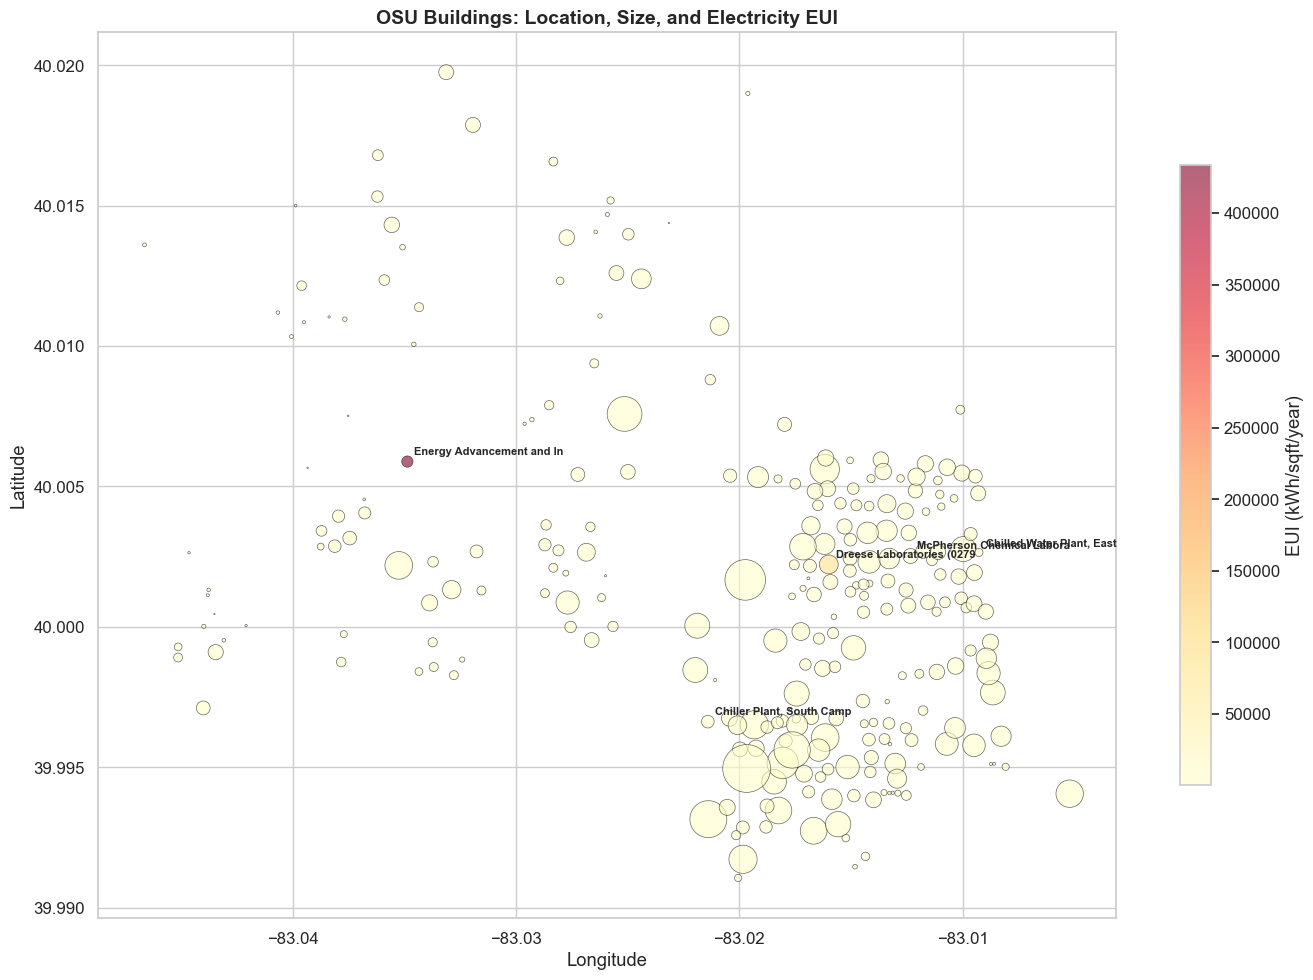

Bubble size = building gross area. Color = Electricity EUI (kWh/sqft/year).


In [92]:
# Geospatial scatter: buildings colored by EUI
# elec_bldg_annual is already built a few cells above:
# elec_bldg_annual = elec_bldg.groupby(...).agg(...); includes grossarea, buildingname, campusname

geo = elec_bldg_annual.dropna(subset=["eui"]).merge(
    buildings[["buildingnumber", "latitude", "longitude"]],
    left_on="simscode",
    right_on="buildingnumber",
    how="inner",
)

# clean numeric coords
geo["latitude"] = pd.to_numeric(geo["latitude"], errors="coerce")
geo["longitude"] = pd.to_numeric(geo["longitude"], errors="coerce")
geo = geo.dropna(subset=["latitude", "longitude", "grossarea"])

# clip extreme EUI outliers
geo = geo[(geo["eui"] > 0) & (geo["eui"] < geo["eui"].quantile(0.99))]

fig, ax = plt.subplots(figsize=(14, 10))
scatter = ax.scatter(
    geo["longitude"],
    geo["latitude"],
    c=geo["eui"],
    cmap="YlOrRd",
    s=geo["grossarea"] / 1000,  # bubble size = area (sqft / 1000)
    alpha=0.6,
    edgecolors="black",
    linewidth=0.5,
)
plt.colorbar(scatter, ax=ax, label="EUI (kWh/sqft/year)", shrink=0.7)
ax.set_title("OSU Buildings: Location, Size, and Electricity EUI", fontsize=14, fontweight="bold")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Annotate top 5 highest EUI buildings
top5 = geo.nlargest(5, "eui")
for _, row in top5.iterrows():
    ax.annotate(
        row["buildingname"][:25],
        (row["longitude"], row["latitude"]),
        fontsize=8,
        fontweight="bold",
        ha="left",
        xytext=(5, 5),
        textcoords="offset points",
    )

plt.tight_layout()
plt.show()
print("Bubble size = building gross area. Color = Electricity EUI (kWh/sqft/year).")


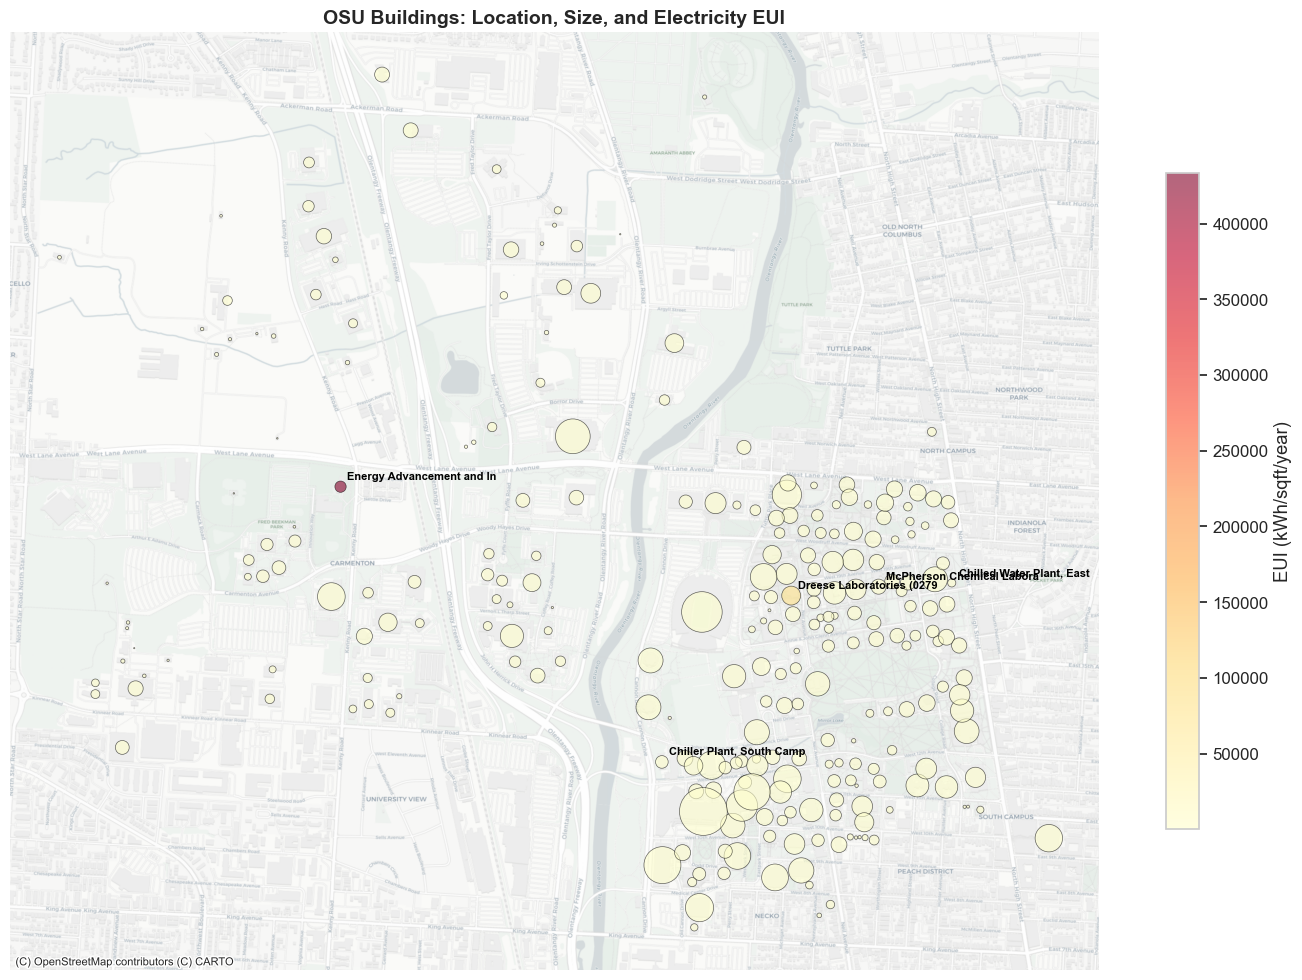

Bubble size = building gross area. Color = Electricity EUI (kWh/sqft/year).


In [93]:
geo_gdf = gpd.GeoDataFrame(
    geo,
    geometry=gpd.points_from_xy(geo['longitude'], geo['latitude']),
    crs="EPSG:4326"  # WGS84 lon/lat
)

# Web map tiles (Google-like) use Web Mercator
geo_gdf = geo_gdf.to_crs(epsg=3857)

import contextily as cx
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 10))

# Scatter on Web Mercator coordinates
scatter = ax.scatter(
    geo_gdf.geometry.x,
    geo_gdf.geometry.y,
    c=geo_gdf['eui'],
    cmap='YlOrRd',
    s=geo_gdf['grossarea'] / 1000,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)

# Add basemap (CartoDB Positron instead of Stamen)
cx.add_basemap(
    ax,
    crs=geo_gdf.crs,
    source=cx.providers.CartoDB.Positron,
    zoom=16  # tweak zoom to taste
)

plt.colorbar(scatter, ax=ax, label='EUI (kWh/sqft/year)', shrink=0.7)
ax.set_title('OSU Buildings: Location, Size, and Electricity EUI', fontsize=14, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()

# Annotate top consumers
top5 = geo_gdf.nlargest(5, 'eui')
for _, row in top5.iterrows():
    ax.annotate(
        row['buildingname'][:25],
        (row.geometry.x, row.geometry.y),
        fontsize=8,
        fontweight='bold',
        ha='left',
        xytext=(5, 5),
        textcoords='offset points',
        color='black'
    )

plt.show()
print('Bubble size = building gross area. Color = Electricity EUI (kWh/sqft/year).')


In [ ]:
import folium

# Make sure we have lon/lat in WGS84 for mapping
geo_latlon = geo_gdf.to_crs(epsg=4326).copy()
geo_latlon["lat"] = geo_latlon.geometry.y
geo_latlon["lon"] = geo_latlon.geometry.x

# Filter only positive EUI values (keep all valid data)
geo_latlon_valid = geo_latlon[geo_latlon["eui"] > 0].copy()

# Define thresholds for color mapping (5th-95th percentile)
min_threshold = geo_latlon_valid["eui"].quantile(0.05)
max_threshold = geo_latlon_valid["eui"].quantile(0.95)

# Find the building with highest EUI overall
max_eui_idx = geo_latlon_valid["eui"].idxmax()
max_eui_value = geo_latlon_valid.loc[max_eui_idx, "eui"]

# Center map on OSU campus
center_lat = float(geo_latlon_valid["lat"].mean())
center_lon = float(geo_latlon_valid["lon"].mean())

m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=15,
    tiles="CartoDB dark_matter"
)

def eui_color(eui):
    """
    Color mapping: yellow-orange-red gradient.
    """
    # Normalize to 0-1 range using thresholds
    normalized = (eui - min_threshold) / (max_threshold - min_threshold) if max_threshold > min_threshold else 0
    normalized = max(0, min(normalized, 1))  # clamp to [0, 1]
    
    # 3-step color ramp
    if normalized < 0.33:
        return "#1ab3d5"  # light yellow (low EUI)
    elif normalized < 0.67:
        return "#5cfe69"  # orange (medium EUI)
    else:
        return "#e31a1c"  # red (high EUI)

# Add bubbles for all buildings
for idx, row in geo_latlon_valid.iterrows():
    # Highlight only the highest EUI building
    is_max = (idx == max_eui_idx)
    
    if is_max:
        edge_color = "#FFFFFF"  # black outline for max
        edge_weight = 3
        fill_opacity = 0.9
    else:
        edge_color = None
        edge_weight = 0
        fill_opacity = 0.6
    
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=max((row["grossarea"] ** 0.5) / 50, 3),
        color=edge_color,
        weight=edge_weight,
        fill=True,
        fill_color=eui_color(row["eui"]),
        fill_opacity=fill_opacity,
        popup=folium.Popup(
            f"<b>{row['buildingname']}</b><br>"
            f"EUI: {row['eui']:.1f} kWh/sqft/yr"
            f"{' <b>(HIGHEST)</b>' if is_max else ''}<br>"
            f"Area: {row['grossarea']:,.0f} sqft",
            max_width=250,
        ),
    ).add_to(m)

# Add legend
legend_html = f"""
<div style="position: fixed; 
     top: 10px; right: 10px; width: 220px; height: 140px; 
     background-color: white; border:2px solid grey; z-index:9999; 
     font-size:14px; padding: 10px">
     <p style="margin: 0; font-weight: bold;">EUI (kWh/sqft/yr)</p>
     <p style="margin: 5px 0;"><span style="background-color: #1ab3d5; padding: 3px 10px;">█</span> Low ({min_threshold:.1f})</p>
     <p style="margin: 5px 0;"><span style="background-color: #5cfe69; padding: 3px 10px;">█</span> Medium</p>
     <p style="margin: 5px 0;"><span style="background-color: #e31a1c; padding: 3px 10px;">█</span> High ({max_threshold:.1f})</p>
     <p style="margin: 5px 0;"><span style="background-color: #e31a1c; padding: 3px 10px; border: 3px solid #000;">█</span> Highest ({max_eui_value:.1f})</p>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

m  # Jupyter will render this as an interactive map
m.save("osu_eui_map.html")

print(f"Map created with {len(geo_latlon_valid)} buildings")
print(f"Color scale range: {min_threshold:.1f} - {max_threshold:.1f} kWh/sqft/yr (5th-95th percentile)")
print(f"Highest EUI building: {geo_latlon_valid.loc[max_eui_idx, 'buildingname']} ({max_eui_value:.1f} kWh/sqft/yr)")

Map created with 262 buildings
Color scale range: 0.3 - 15.7 kWh/sqft/yr (5th-95th percentile)
Highest EUI building: Energy Advancement and Innovation Center (1044) (433612.6 kWh/sqft/yr)


## 7. Save Cleaned Data for Downstream Notebooks

We create clean, merged parquet files partitioned by utility type. We also prepare a daily weather summary and building-level annual aggregates. These serve as the foundation for all downstream analysis.

In [95]:
# Extract date from readingtime for daily-level aggregation
meter['date'] = meter['readingtime'].dt.date

# Save full meter data merged with buildings (for notebooks that need it)
# Only keep rows with valid building match
meter_clean = meter[meter['simscode'].isin(matched)].copy()
meter_clean = meter_clean.merge(
    buildings[['buildingnumber', 'buildingname', 'campusname', 'grossarea', 
               'floorsaboveground', 'floorsbelowground', 'constructiondate',
               'latitude', 'longitude', 'building_age']],
    left_on='simscode', right_on='buildingnumber', how='left'
)
meter_clean['grossarea'] = pd.to_numeric(meter_clean['grossarea'], errors='coerce')
meter_clean['latitude'] = pd.to_numeric(meter_clean['latitude'], errors='coerce')
meter_clean['longitude'] = pd.to_numeric(meter_clean['longitude'], errors='coerce')
meter_clean['floorsaboveground'] = pd.to_numeric(meter_clean['floorsaboveground'], errors='coerce')
meter_clean['floorsbelowground'] = pd.to_numeric(meter_clean['floorsbelowground'], errors='coerce')

# Save per utility type
for util in meter_clean['utility'].unique():
    subset = meter_clean[meter_clean['utility'] == util]
    outpath = OUTPUT_DIR / f'meter_{util.lower()}.parquet'
    subset.to_parquet(outpath, index=False)
    print(f'Saved {outpath.name}: {len(subset):,} rows')

# Save full merged dataset
meter_clean.to_parquet(OUTPUT_DIR / 'meter_all_utilities.parquet', index=False)
print(f'\nSaved meter_all_utilities.parquet: {len(meter_clean):,} rows')

ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - `Import pyarrow` failed. pyarrow is required for parquet support. Use pip or conda to install the pyarrow package.
 - `Import fastparquet` failed. fastparquet is required for parquet support. Use pip or conda to install the fastparquet package.

In [ ]:
# Daily weather summary
daily_weather = weather.groupby('date_only').agg(
    temp_mean=('temperature_2m', 'mean'),
    temp_min=('temperature_2m', 'min'),
    temp_max=('temperature_2m', 'max'),
    humidity_mean=('relative_humidity_2m', 'mean'),
    dew_point_mean=('dew_point_2m', 'mean'),
    precip_total=('precipitation', 'sum'),
    solar_radiation_mean=('shortwave_radiation', 'mean'),
    wind_speed_mean=('wind_speed_10m', 'mean'),
    cloud_cover_mean=('cloud_cover', 'mean'),
    apparent_temp_mean=('apparent_temperature', 'mean')
).reset_index()
daily_weather.columns = ['date'] + list(daily_weather.columns[1:])

# Compute HDD and CDD (base 65F)
daily_weather['hdd_65'] = np.maximum(65 - daily_weather['temp_mean'], 0)
daily_weather['cdd_65'] = np.maximum(daily_weather['temp_mean'] - 65, 0)

daily_weather.to_parquet(OUTPUT_DIR / 'daily_weather.parquet', index=False)
print(f'Saved daily_weather.parquet: {len(daily_weather)} days')

# Also save hourly weather
weather.to_parquet(OUTPUT_DIR / 'weather_hourly.parquet', index=False)
print(f'Saved weather_hourly.parquet: {len(weather)} hours')

# Save building metadata
buildings.to_parquet(OUTPUT_DIR / 'buildings.parquet', index=False)
print(f'Saved buildings.parquet: {len(buildings)} buildings')

Saved daily_weather.parquet: 362 days
Saved weather_hourly.parquet: 8688 hours
Saved buildings.parquet: 1287 buildings


In [ ]:
# Summary statistics for the notebook
print('=' * 60)
print('NOTEBOOK 1 SUMMARY: Data Loading & EDA')
print('=' * 60)
print(f'Total meter readings loaded: {len(meter):,}')
print(f'Date range: {meter["readingtime"].min()} to {meter["readingtime"].max()}')
print(f'Unique meters: {meter["meterid"].nunique():,}')
print(f'Unique buildings (via simscode): {meter["simscode"].nunique():,}')
print(f'Buildings with metadata match: {len(matched)}')
print(f'Utility types: {sorted(meter["utility"].unique())}')
print(f'\nWeather: {len(weather):,} hourly records over {len(daily_weather)} days')
print(f'Buildings metadata: {len(buildings)} buildings across {buildings["campusname"].nunique()} campuses')
print(f'\nOutput files saved to: {OUTPUT_DIR}')
print('Ready for downstream notebooks.')

NOTEBOOK 1 SUMMARY: Data Loading & EDA
Total meter readings loaded: 8,964,408
Date range: 2025-01-01 05:00:00 to 2026-01-01 04:00:00
Unique meters: 1,030


Unique buildings (via simscode): 288
Buildings with metadata match: 285
Utility types: ['COOLING', 'COOLING_POWER', 'ELECTRICAL_POWER', 'ELECTRICITY', 'GAS', 'HEAT', 'OIL28SEC', 'STEAM', 'STEAMRATE']

Weather: 8,688 hourly records over 362 days
Buildings metadata: 1287 buildings across 8 campuses

Output files saved to: /Users/Siddarth/Data IO/processed
Ready for downstream notebooks.


## Key Findings

1. **Data Volume**: ~9M meter readings across 12 months of 2025, covering 1,030 meters and 288 buildings.
2. **Join Quality**: After normalizing leading-zero simscodes, ~98% of meter readings match building metadata (up from 70% before fix). The documentation specifies simsCode as an integer — leading zeros in the CSV were join-key artifacts.
3. **Data Completeness**: ~92% of rows have perfect (0% missing) readings. About 7.75% of rows have significant missing data, concentrated in certain meters.
4. **9 Utility Types**: 6 energy utilities (ELECTRICITY, STEAM, HEAT, GAS, COOLING, OIL28SEC) and 3 power utilities (ELECTRICAL_POWER, STEAMRATE, COOLING_POWER). Per documentation, these must be analyzed separately — different physical quantities with different units.
5. **Seasonal Patterns**: Clear monthly variation aligned with HVAC seasons — heating peaks in winter (STEAM, HEAT, GAS), cooling peaks in summer (COOLING). Weekday/weekend differences confirm campus operational schedules.
6. **Building Diversity**: Buildings range from 19th century to 2024 construction, spanning 8 campuses with Columbus (485 buildings) dominating. Building age shows a weak positive correlation with EUI.
7. **District Energy**: Per documentation, meter data reflects delivered energy from centralized campus systems. Some buildings share district heating/cooling, and a single meter may serve aggregated loads.